In [473]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt

In [474]:
pip install -U sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 85 kB 312 kB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=3761a5e319ab46bf1256cf1c963b93ec8e66197e0fbfca4b05000114e7093cf9
  Stored in directory: /home/bobi/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.1
    Uninstalling sentence-transformers-2.2.1:
      Successfully uninstalled sentence-transformers-2.2.1
Note: you may need to restart the kernel to use updated package

In [475]:
from sentence_transformers import SentenceTransformer
hugface_mdl = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v1')

In [476]:
mentions_df = pd.read_csv('mentions.csv', dtype=str)
print(f"Len(mentions_df)={len(mentions_df)}")
mentions_df.head(2)



Len(mentions_df)=18625


,idx,left_context,link_title,link_text,right_context,url,mention_in_page
0,0,стил е съвременният международно признат,светски,NaN,календар на който се основава,NaN,Григориански календар
1,1,е съвременният международно признат светски,календар,NaN,на който се основава и,NaN,Григориански календар


In [477]:
mentions_df['link_repr'] = mentions_df.apply(lambda x: x['link_title'] if x['link_text']is None else x['link_title'], axis=1)
mentions_df.head(2)

,idx,left_context,link_title,link_text,right_context,url,mention_in_page,link_repr
0,0,стил е съвременният международно признат,светски,NaN,календар на който се основава,NaN,Григориански календар,светски
1,1,е съвременният международно признат светски,календар,NaN,на който се основава и,NaN,Григориански календар,календар


In [478]:
entities_df = pd.read_csv('entities.csv')
print(f"Len(entities_df)={len(entities_df)}")
entities_df.head(2)

Len(entities_df)=1001


,idx,title,text,url
0,0,Григориански календар,'Григорианският календар (понякога наричан и Г...,https://bg.wikipedia.org/wiki/%D0%93%D1%80%D0%...
1,1,GNU General Public License,GNU General Public License (на български преве...,https://bg.wikipedia.org/wiki/GNU_General_Publ...


In [479]:
# Merge mentions and entities (inner merge)
merge_df = mentions_df.merge(entities_df, \
                           left_on='link_title', \
                           right_on='title', \
                           how='inner',
                           suffixes=['_mention', '_entity'])
print('Eligible mentions: ', len(merge_df))
merge_df.head(2)

Eligible mentions:  3739


,idx_mention,left_context,link_title,link_text,right_context,url_mention,mention_in_page,link_repr,idx_entity,title,text,url_entity
0,6,е въведен в употреба на,4 октомври,NaN,1582 г в съответствие с,NaN,Григориански календар,4 октомври,62,4 октомври,4 октомври е 277-ият ден в годината според гри...,https://bg.wikipedia.org/wiki/4_%D0%BE%D0%BA%D...
1,205,са следните За събитията до,4 октомври,NaN,1582 г включително има само,NaN,Приемане на григорианския календар,4 октомври,62,4 октомври,4 октомври е 277-ият ден в годината според гри...,https://bg.wikipedia.org/wiki/4_%D0%BE%D0%BA%D...


In [480]:
merge_df.reset_index(inplace=True)

In [481]:
merge_df['idx_entity'].nunique()

682

In [482]:
merge_df.size

48607

In [483]:
class MentionEntityDataset(Dataset):
    def __init__(self, hugface_mdl, merge_df):
        self.mention_vecs = hugface_mdl.encode(pd.array( \
            merge_df['left_context'] +' ' +\
            merge_df['link_repr'] + ' ' + \
            merge_df['right_context']))
        #self.entities_vec = hugface_mdl.encode(pd.array( \
        #    merge_df['title'] +' ' +\
        #    merge_df['text']))
        #cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        #self.cos_sm = cos(torch.from_numpy(self.mention_vecs), torch.from_numpy(self.entities_vec))
        #print("COS:", output)
        self.idx_entity = merge_df['idx_entity'];
        assert(len(self.mention_vecs) == len(self.idx_entity))

    def __len__(self):
        return len(self.mention_vecs)

    def __getitem__(self, idx):
        return self.mention_vecs[idx].reshape(-1), self.idx_entity[idx].item()

In [484]:
dataset = MentionEntityDataset(hugface_mdl, merge_df)
len(dataset)

3739

In [501]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"len(train_dataset)={len(train_dataset)}")
print(f"len(test_dataset)={len(test_dataset)}")

len(train_dataset)=2991
len(test_dataset)=748


In [502]:
class MentionToEntityNet(nn.Module):
    def __init__(self, out_size, in_size=384, dropout=0.5):
        super(MentionToEntityNet, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 2500),
            nn.ReLU(),
            nn.Linear(2500, 1500),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(1500, out_size),
        )
        self.linear_relu_stack.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
            
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        # Softmax is used in evaluation later on, 
        # This method returns logits directly in order
        # to call CrossEntropyLoss on logits
        return logits


In [539]:
model = MentionToEntityNet(out_size=len(entities_df))
print(model)

MentionToEntityNet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=384, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=1500, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=1500, out_features=1001, bias=True)
  )
)


In [540]:
def accuracy(model, dataset):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                      shuffle=False, drop_last=False)
    sum_correct=0
    for x, y in dataloader:
        with torch.no_grad():
            logits = model(x)
            y_hat = torch.argmax(logits, dim=1)
            sum_correct += torch.sum(y_hat.view(-1) == y).item()
    
    accuracy = sum_correct / len(dataset)
    return accuracy

In [541]:
# Training cycle
MAX_EPOCHS = 40
BATCH_SIZE = 32
DISPLAY_STEP = 4
LEARNING_RATE = 0.001
def train(model, train_dataset, test_dataset):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fct = nn.CrossEntropyLoss()
    #loss_fct = nn.CosineSimilarity(eps=1e-6)
    model.train()
    epoch_losses = []
    for epoch in tqdm(range(1, MAX_EPOCHS+1)):
        losses = []
        dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=False)
        for x, y in dataloader:
            optimizer.zero_grad()
            predicted = model(x)
            loss = loss_fct(predicted, y)
            loss.backward()
            optimizer.step()
            loss_value = loss.item()
            losses.append(loss_value)
        
        train_loss_value = np.mean(losses)
        epoch_losses.append(train_loss_value)
        # Display logs per each DISPLAY_STEP
        if (epoch) % DISPLAY_STEP == 0:
            train_acc = accuracy(model, train_dataset)
            test_acc = accuracy(model, test_dataset)
            print(f"Epoch: {epoch:04d} loss={train_loss_value:.5f}, train_acc={train_acc:.5f},test_acc={test_acc:.5f}  ")
    return epoch_losses    
    

epoch_losses = train(model, train_dataset, test_dataset)
print ("Optimization Finished!")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0004 loss=3.74424, train_acc=0.38315,test_acc=0.26203  
Epoch: 0008 loss=1.11976, train_acc=0.79472,test_acc=0.38770  
Epoch: 0012 loss=0.42701, train_acc=0.92745,test_acc=0.39706  
Epoch: 0016 loss=0.22309, train_acc=0.96122,test_acc=0.40508  
Epoch: 0020 loss=0.14774, train_acc=0.97727,test_acc=0.40508  
Epoch: 0024 loss=0.10322, train_acc=0.98061,test_acc=0.39706  
Epoch: 0028 loss=0.11734, train_acc=0.98128,test_acc=0.39305  
Epoch: 0032 loss=0.05949, train_acc=0.98830,test_acc=0.38770  
Epoch: 0036 loss=0.07779, train_acc=0.98195,test_acc=0.38369  
Epoch: 0040 loss=0.07814, train_acc=0.98429,test_acc=0.39572  
Optimization Finished!


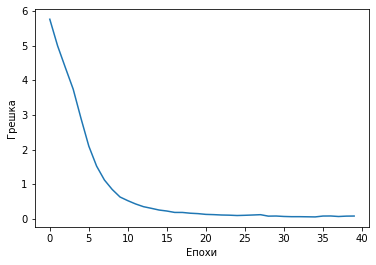

In [561]:
plt.xlabel("Епохи")
plt.ylabel("Грешка")
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.show()

# Evaluation

In [557]:
# https://bg.wikinews.org/wiki/%D0%A4%D0%B8%D0%BD%D0%B0%D0%BD%D1%81%D0%B8%D1%80%D0%B0%D0%BD%D0%B5%D1%82%D0%BE_%D0%BD%D0%B0_%D0%A2%D0%B5%D0%B2%D0%B0%D1%82%D1%80%D0%BE%D0%BD_%D1%89%D0%B5_%D0%B1%D1%8A%D0%B4%D0%B5_%D0%BF%D1%80%D0%B5%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%B5%D0%BD%D0%BE
text = """
Дни, използвани от слънчевите календари.
При слънчевите календари датата отговаря 
на слънчевия ден. Денят може да се състои 
от периода между изгрев и залез слънце, 
последван от нощта, или може да представлява 
времето между повтарящи се събития, например 
два залеза. Дължината може да се променя малко 
през годината или може да се използва среден 
слънчев ден. Други типове календари също могат 
да използват слънчевия ден.

Юлиански и Григориански календар.
Юлианският календар е въведен от римския диктатор 
Юлий Цезар през 46 г. пр.н.е. При него месеците са 
по-дълги от лунния цикъл и затова той не е удобен за 
следене на лунните фази, за сметка на това много точно 
показва сезоните. Обикновените години имат 365 дена, 
а всяка четвърта година е високосна, което означава, 
че има 366 дни. Така продължителността на средната 
година е 365,25 дни.
"""


stop_words = {"и","на","в" ".", "се", "да", \
              "от", "или", "през", "а", "може",\
              "например", "той", "не", "че", "за", "е"}


In [558]:
text = re.sub(r"[,\\.\"]", r"", text.strip())
tokens = text.split()
tokens[0:5]

['Дни', 'използвани', 'от', 'слънчевите', 'календари']

In [559]:
model.eval()
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
MAX_SPAN_MENTION = 2
with torch.no_grad():
    for i in range(len(tokens)):
        if tokens[i].lower() in stop_words :
            continue;
        for span in range(MAX_SPAN_MENTION): 
            if tokens[min(i+span,len(tokens)-1)].lower() in stop_words:
                continue;
            left_tok_start = max(i+span-5,0)
            right_tok_end = min(i+span+5,len(tokens))
            # On stop word continue
            if tokens[i] in stop_words or \
                tokens[min(i+span, len(tokens)-1)] in stop_words:
                continue;
            #print(" ".join(tokens[left_tok_start: right_tok_end]))
            vec = hugface_mdl.encode(" ".join(tokens[left_tok_start: right_tok_end]))
            predicted = model(torch.from_numpy(vec).reshape(1,-1))
            probabilities = F.softmax(predicted.view(-1),dim=0)
            max_prob = torch.max(probabilities)
            argmax_prob = torch.argmax(probabilities)
            
            if max_prob > 0.98:
                print(f"{' '.join(tokens[i:i+span+1])}=={max_prob:.5f}=>{entities_df.iloc[argmax_prob.item()]['title']}")
                #break
        
    

между изгрев==0.99325=>Варна
изгрев==0.99325=>Варна
използва среден==0.99609=>Европа
среден==0.99609=>Европа
слънчев ден==0.99627=>Григориански календар
ден==0.99627=>Григориански календар
ден Други==0.98896=>Григориански календар
Други==0.98896=>Григориански календар
римския диктатор==0.99753=>България
диктатор==0.99753=>България
удобен==0.98141=>Рим
сметка==0.98468=>1 април
365 дена==0.98328=>Обикновена година, започваща във вторник
дена==0.98328=>Обикновена година, започваща във вторник
високосна==0.99687=>Варна
дни==0.99435=>Григориански календар
